# Titanic Capstone Project
The goal is to work with historical passenger data from the Titanic disaster to predict whether a passenger survived or not. Using this dataset, your team will train a machine learning model and integrate it into a Django-based web application where users can enter passenger information and receive predictions.

**Dataset** -Titanic dataset provided by Kaggle: 
https://www.kaggle.com/c/titanic/data. 

Each row in the dataset represents one passenger aboard the Titanic. The target variable is 'Survived', which indicates whether the passenger survived (1) or not (0).
 
The dataset contains numerical and categorical variables, missing values, and mixed data types. Handling these challenges is an essential part of the assignment.

## Inspect the data

In [212]:
import pandas as pd
import numpy as np

##### 1.Load data from csv

In [213]:
x_train = pd.read_csv('./titanic_data/train.csv')
y_train = pd.read_csv('./titanic_data/test.csv')

##### Print shape of dataset rows and columns

In [214]:
print(f'Train data set shape (rows, columns) ', x_train.shape)
print(f'Test data set shape (rows, columns) ', y_train.shape)

Train data set shape (rows, columns)  (891, 12)
Test data set shape (rows, columns)  (418, 11)


In [215]:
x_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Check datatypes of all fields

In [216]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [217]:
print(x_train.isnull().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


##### Analyzing the above datatypes. 
- Name is a object that contains text.
- Sex(0,1) & Embarked(S,C,Q) are objects. 
- Cabin is a Mixed String field(letters & numbers mixed) with lot of missing values.
- Age and Fare are float type.
- Passenger, survived, Pclass, Sibsp, Parch are integers.

##### Convert Datatypes to desired ones

In [218]:
x_train['Age']=np.ceil(x_train['Age']).astype('Int64')

In [219]:
#from itables import show # pip install itables to show as scrollable table
#show(x_train)
x_train[['Age']] 

,Age
0,22
1,38
2,26
3,35
4,35
...,...
886,27
887,19
888,<NA>
889,26


#### One hot encoding, Replacing Gender with 0 or 1

In [220]:
x_train['Sex'] = x_train['Sex'].map({'male': 0, 'female': 1})

In [221]:
x_train[['Sex']]

,Sex
0,0
1,1
2,1
3,1
4,0
...,...
886,0
887,1
888,1
889,0


### Handling Missing data for Age Using Title extraction, groupby title group and median of each group used to fill the data

In [222]:
# 1. Extract Titles from Names
x_train['Title'] = x_train['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# 2. Define your groups
title_mapping = {
    'Miss': 'Miss', 'Ms': 'Miss', 'Mlle': 'Miss',
    'Master': 'kid',
    'Mr': 'Mr', 'Mrs': 'Mrs', 'Mme': 'Mrs', 'Countess': 'Mrs', 'Lady': 'Mrs',
    'Dr': 'Dr', 'Capt': 'Mr', 'Col': 'Mr', 'Major': 'Mr', 'Don': 'Mr', 'Sir': 'Mr', 
    'Jonkheer': 'Mr', 'Rev': 'Mr'
}
x_train['TitleGroup'] = x_train['Title'].map(title_mapping).fillna('Other')
x_train['Age'] = x_train['Age'].astype(float)
# 3. Fill missing ages
# We convert to float first to ensure the math works, then fill the NaNs
median_map = x_train.groupby('TitleGroup')['Age'].transform('median')
x_train['Age'] = x_train['Age'].fillna(median_map)

# 4. Final Conversion
# We use .astype(float) BEFORE .astype('Int64') to resolve the 'Object' casting error
x_train['Age'] = np.ceil(x_train['Age'].astype(float)).astype('Int64')

print("Success! Missing values filled and Age converted to Integer.")

Success! Missing values filled and Age converted to Integer.


In [223]:
# Check the medians for each title group
print(x_train.groupby('TitleGroup')['Age'].median())

# See the first 10 rows to confirm the integers look right
display(x_train[['Name', 'TitleGroup', 'Age']].head(10))

TitleGroup
Dr      47.0
Miss    21.0
Mr      30.0
Mrs     35.0
kid      4.0
Name: Age, dtype: Float64


,Name,TitleGroup,Age
0,"Braund, Mr. Owen Harris",Mr,22
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs,38
2,"Heikkinen, Miss. Laina",Miss,26
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs,35
4,"Allen, Mr. William Henry",Mr,35
5,"Moran, Mr. James",Mr,30
6,"McCarthy, Mr. Timothy J",Mr,54
7,"Palsson, Master. Gosta Leonard",kid,2
8,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",Mrs,27
9,"Nasser, Mrs. Nicholas (Adele Achem)",Mrs,14


In [224]:
display(x_train[['Name', 'TitleGroup', 'Age']].iloc[885:891])

,Name,TitleGroup,Age
885,"Rice, Mrs. William (Margaret Norton)",Mrs,39
886,"Montvila, Rev. Juozas",Mr,27
887,"Graham, Miss. Margaret Edith",Miss,19
888,"Johnston, Miss. Catherine Helen ""Carrie""",Miss,21
889,"Behr, Mr. Karl Howell",Mr,26
890,"Dooley, Mr. Patrick",Mr,32


In [225]:
from itables import show # pip install itables to show as scrollable table
show(x_train[['Name','Age']])

Loading ITables v2.7.0 from the internet... (need help?)


In [226]:
x_train[0:10]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TitleGroup
0,1,0,3,"Braund, Mr. Owen Harris",0,22,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",1,26,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35,1,0,113803,53.1000,C123,S,Mrs,Mrs
4,5,0,3,"Allen, Mr. William Henry",0,35,0,0,373450,8.0500,NaN,S,Mr,Mr
5,6,0,3,"Moran, Mr. James",0,30,0,0,330877,8.4583,NaN,Q,Mr,Mr
6,7,0,1,"McCarthy, Mr. Timothy J",0,54,0,0,17463,51.8625,E46,S,Mr,Mr
7,8,0,3,"Palsson, Master. Gosta Leonard",0,2,3,1,349909,21.0750,NaN,S,Master,kid
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,27,0,2,347742,11.1333,NaN,S,Mrs,Mrs
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14,1,0,237736,30.0708,NaN,C,Mrs,Mrs


#### Embarked field is missing 2 values. So, fill it with the Most frequent value in titanic dataset i.e. 'S' Southampton port.

In [227]:
print(x_train['Embarked'].isnull().sum())

2


In [228]:
# 1. Find the most frequent port (the mode)
# .mode() returns a Series, so we take the first item [0]
most_freq_port = x_train['Embarked'].mode()[0]

# 2. Fill the missing values
x_train['Embarked'] = x_train['Embarked'].fillna(most_freq_port)

# 3. Verify there are no more nulls in the column
print(f"Missing values in Embarked: {x_train['Embarked'].isnull().sum()}")
print(f"Filled with: {most_freq_port}")
x_train['Embarked'] = x_train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

Missing values in Embarked: 0
Filled with: S


In [229]:
x_train['Fare'].isnull().sum()

np.int64(0)

#### Fill the empty values in cabin by Unknown

In [230]:
x_train['Cabin'].fillna('Unknown')

0      Unknown
1          C85
2      Unknown
3         C123
4      Unknown
        ...   
886    Unknown
887        B42
888    Unknown
889       C148
890    Unknown
Name: Cabin, Length: 891, dtype: object

#### Calculating the family size of each person and add it as a column

In [231]:
x_train['FamilySize'] = x_train['SibSp'] + x_train['Parch'] + 1

### Features Selection and CSV export
Age * Passenger class to increase model accuracy

In [232]:
# Select features based on your project requirements
# We keep Age, Pclass, Sex, SibSp, Parch, Fare, and the encoded Ports
x_train['Age_Class'] = x_train['Age'] * x_train['Pclass']
features = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'TitleGroup','FamilySize','Embarked', 'Age_Class']

# Create the final training dataframe
df_final = x_train[features].copy()

# Save to CSV
df_final.to_csv('titanic_cleaned_training_data.csv', index=False)
print("Cleaned data saved to titanic_cleaned_training_data.csv")


Cleaned data saved to titanic_cleaned_training_data.csv


Dr      47.0
Miss    21.0
Mr      30.0
Mrs     35.0
kid      4.0

In [233]:
print(df_final['TitleGroup'].unique().sum())

MrMrsMisskidDr


In [239]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, classification_report


# Define X (features) and y (target)
# We drop 'Survived' from X and also 'TitleGroup' if you want to keep it simple for now
X = df_final.drop(['Survived', 'TitleGroup','PassengerId'], axis=1) 
y = df_final['Survived']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Model
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Fit/Train the model
model.fit(X_train, y_train)

print("Model training complete.")

Model training complete.


### Accuracy, Confusion Matrix, F-1 Score Metric

In [243]:
y_pred = model.predict(X_test)# 1. Accuracy

acc = accuracy_score(y_test, y_pred)

print(f"Model Accuracy: {acc:.2%}")# 2. Confusion Matrix

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print()# 3. Additional Metric: Classification Report (Precision, Recall, F1-score)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
f1 = f1_score(y_test, y_pred)
print(f"Final F1-Score: {f1:.4f}")

Model Accuracy: 83.24%

Confusion Matrix:


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86       105
           1       0.84      0.73      0.78        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

Final F1-Score: 0.7826


#### Using different Models to check which model gives best accuracy

In [241]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=5),
    "Gradient Boosting": HistGradientBoostingClassifier()
}

for name, m in models.items():
    m.fit(X_train, y_train)
    acc = accuracy_score(y_test, m.predict(X_test))
    print(f"{name} Accuracy: {acc:.2%}")

Logistic Regression Accuracy: 81.01%
Random Forest Accuracy: 82.68%
Gradient Boosting Accuracy: 84.92%


### PLot the Confusion matrix

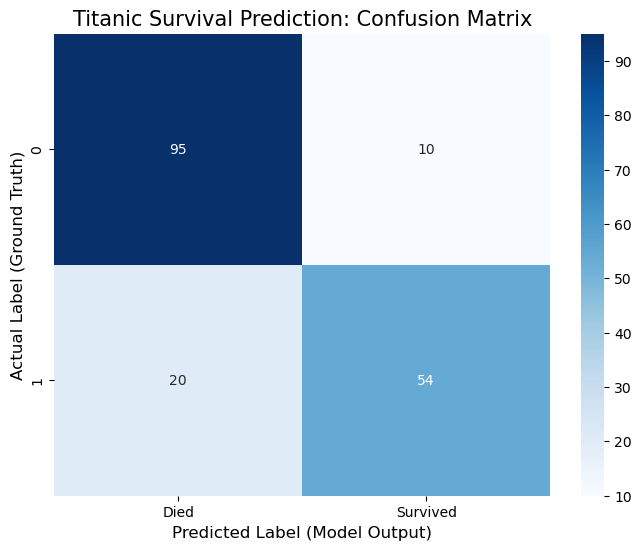

In [244]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define labels for the matrix
labels = ['Died', 'Survived']

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=labels)

# Add titles and labels for clarity
plt.title('Titanic Survival Prediction: Confusion Matrix', fontsize=15)
plt.ylabel('Actual Label (Ground Truth)', fontsize=12)
plt.xlabel('Predicted Label (Model Output)', fontsize=12)

# Display the plot
plt.show()

### Clean and Prepare the Test dataset

##### Load test dataset

In [156]:
x_test_real = pd.read_csv('./titanic_data/test.csv')
print("Rows and columns in test data:",x_test_real.shape)
x_test_real.info()

Rows and columns in test data: (418, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


In [157]:
print(x_test_real.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


#### One hot encoding to gender and Embarked 

In [255]:
x_test_real['Sex'] = x_test_real['Sex'].str.lower().str.strip().map({'male': 0, 'female': 1})
print(x_test_real['Sex'].head())

AttributeError: Can only use .str accessor with string values!

In [159]:
x_test_real['Embarked'] = x_test_real['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

#### Handle missing values for Age column by title extraction

In [254]:
# 1. Extract Titles from Names
x_test_real['Title'] = x_test_real['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

# 2. Define your groups
title_mapping = {
    'Miss': 'Miss', 'Ms': 'Miss', 'Mlle': 'Miss',
    'Master': 'kid',
    'Mr': 'Mr', 'Mrs': 'Mrs', 'Mme': 'Mrs', 'Countess': 'Mrs', 'Lady': 'Mrs',
    'Dr': 'Dr', 'Capt': 'Mr', 'Col': 'Mr', 'Major': 'Mr', 'Don': 'Mr', 'Sir': 'Mr', 
    'Jonkheer': 'Mr', 'Rev': 'Mr'
}
x_test_real['TitleGroup'] = x_test_real['Title'].map(title_mapping).fillna('Other')
#x_test_real['Age'] = x_test_real['Age'].astype(float)
# 3. Fill missing ages
# We convert to float first to ensure the math works, then fill the NaNs
median_map = x_train.groupby('TitleGroup')['Age'].transform('median')
x_test_real['Age'] = x_test_real['Age'].fillna(median_map)

# 4. Final Conversion
# We use .astype(float) BEFORE .astype('Int64') to resolve the 'Object' casting error
x_test_real['Age'] = np.ceil(x_test_real['Age'].astype(float)).astype('Int64')

print("Success! Missing values filled and Age converted to Integer.")

Success! Missing values filled and Age converted to Integer.


In [253]:
# Check the medians for each title group
print(x_test_real.groupby('TitleGroup')['Age'].median())

# See the first 10 rows to confirm the integers look right
display(x_test_real[['Name', 'TitleGroup', 'Age']].head(10))

TitleGroup
Dr       53.0
Miss     23.0
Mr       30.0
Mrs      34.0
Other    39.0
kid       9.0
Name: Age, dtype: Float64


,Name,TitleGroup,Age
0,"Kelly, Mr. James",Mr,35
1,"Wilkes, Mrs. James (Ellen Needs)",Mrs,47
2,"Myles, Mr. Thomas Francis",Mr,62
3,"Wirz, Mr. Albert",Mr,27
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",Mrs,22
5,"Svensson, Mr. Johan Cervin",Mr,14
6,"Connolly, Miss. Kate",Miss,30
7,"Caldwell, Mr. Albert Francis",Mr,26
8,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",Mrs,18
9,"Davies, Mr. John Samuel",Mr,21


In [252]:
x_test_real['Cabin'] = x_test_real['Cabin'].fillna('Unknown')
x_test_real['Cabin']

0      Unknown
1      Unknown
2      Unknown
3      Unknown
4      Unknown
        ...   
413    Unknown
414       C105
415    Unknown
416    Unknown
417    Unknown
Name: Cabin, Length: 418, dtype: object

#### Calculate family size

In [250]:
x_test_real['FamilySize'] = x_test_real['SibSp'] + x_test_real['Parch'] + 1

In [251]:
x_test_real['FamilySize']

0      1
1      2
2      1
3      1
4      3
      ..
413    1
414    1
415    1
416    1
417    3
Name: FamilySize, Length: 418, dtype: int64

In [249]:
x_test_real[0:10]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,TitleGroup,FamilySize,Age_Class
0,892,3,"Kelly, Mr. James",0,35,0,0,330911,7.8292,Unknown,2,Mr,Mr,1,105
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",1,47,1,0,363272,7.0000,Unknown,0,Mrs,Mrs,2,141
2,894,2,"Myles, Mr. Thomas Francis",0,62,0,0,240276,9.6875,Unknown,2,Mr,Mr,1,124
3,895,3,"Wirz, Mr. Albert",0,27,0,0,315154,8.6625,Unknown,0,Mr,Mr,1,81
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1,22,1,1,3101298,12.2875,Unknown,0,Mrs,Mrs,3,66
5,897,3,"Svensson, Mr. Johan Cervin",0,14,0,0,7538,9.2250,Unknown,0,Mr,Mr,1,42
6,898,3,"Connolly, Miss. Kate",1,30,0,0,330972,7.6292,Unknown,2,Miss,Miss,1,90
7,899,2,"Caldwell, Mr. Albert Francis",0,26,1,1,248738,29.0000,Unknown,0,Mr,Mr,3,52
8,900,3,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1,18,0,0,2657,7.2292,Unknown,1,Mrs,Mrs,1,54
9,901,3,"Davies, Mr. John Samuel",0,21,2,0,A/4 48871,24.1500,Unknown,0,Mr,Mr,3,63


#### Feature selection and export to csv

In [248]:
# Select features based on your project requirements
# We keep Age, Pclass, Sex, SibSp, Parch, Fare, and the encoded Ports
x_test_real['Age_Class'] = x_test_real['Age'] * x_test_real['Pclass']
features = ['PassengerId','Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'TitleGroup','FamilySize','Embarked','Age_Class']

# Create the final training dataframe
test_real = x_train[features].copy()

# Save to CSV
test_real.to_csv('titanic_cleaned_test_data.csv', index=False)
print("Cleaned data saved to titanic_cleaned_training_data.csv")

Cleaned data saved to titanic_cleaned_training_data.csv


### Predict the test data using the trained model

In [247]:
X_test_real = x_test_real[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize','Embarked','Age_Class']]

# 4. Predict the unknown outcomes
test_predictions = model.predict(X_test_real)

# 5. Attach predictions to the PassengerIds
submission = pd.DataFrame({
    "PassengerId": x_test_real["PassengerId"],
    "Survived": test_predictions
})

print(submission.head())

#submission.to_csv('titanic_predictions_output.csv', index=False)

# print("File saved successfully to your folder!")

   PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0


In [246]:
submission.to_csv('titanic_predictions_output.csv', index=False)

print("File saved successfully to your folder!")

File saved successfully to your folder!


### Buid and save the pipeline

In [245]:
import joblib
from sklearn.pipeline import Pipeline
titanic_pipeline = Pipeline([
        ('model', RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42))
])

titanic_pipeline.fit(X_train, y_train)
joblib.dump(titanic_pipeline, 'titanic_model_pipeline.pkl')
print("Pipeline saved successfully!")

Pipeline saved successfully!
